In [1]:
# Importing required libraries
import sqlite3
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# DB connection for loading data
db_connection = sqlite3.connect('../Data Collection/Data/Database/job_database.db')
product_df = pd.read_sql_query('select * from product_info',db_connection)

In [3]:
# Print few records
product_df.head()

,product_name,rating,no_of_rating,price,color_available,size_available,brand,description,img_src,date,time,link,type
0,MAHA YOGI Hoodies Tie Dye Sweatshirt Long Slee...,4.4 out of 5,33 global ratings,$52.99,"Black, Green, Purple, Yellow, Red,","Select, Small, Medium, Large, X-Large, XX-Large,",Visit the MAHA YOGI Store,100% Cotton\nPull On closure\nMachine Wash\nSo...,https://m.media-amazon.com/images/I/71H7f7bn+r...,10/27/2021,14:49:03,https://www.amazon.ca/gp/slredirect/picassoRed...,Hoodie/Sweatshirt
1,"Gildan Men’s Fleece Hooded Sweatshirt, Style G...",4.5 out of 5,"23,052 global ratings",$16.99,"Charcoal, Red, Royal, White, Forest Green, Mar...","Select, Small, Medium, Large, X-Large, XX-Larg...",Visit the Gildan Store,"50% Cotton, 50% Polyester\nNot\nPull On closur...",https://m.media-amazon.com/images/I/81GgkxeKGa...,10/27/2021,14:49:36,https://www.amazon.ca/GILDAN-Heavy-Fleece-Hood...,Hoodie/Sweatshirt
2,Hanes mens Pullover Ultimate Heavyweight Fleec...,4.3 out of 5,"16,163 global ratings",$20.80,"Oxford Gray, White, Black, Navy, Deep Red, Lig...","Select, Small, Medium, Large, X-Large, XX-Larg...",Visit the Hanes Store,"90% Cotton, 10% Polyester\nPull On closure\nMa...",https://m.media-amazon.com/images/I/71hlZVUtDu...,10/27/2021,14:49:47,https://www.amazon.ca/Hanes-Pullover-Ultimate-...,Hoodie/Sweatshirt
3,"Gildan Men’s Fleece Crewneck Sweatshirt, Style...",4.6 out of 5,"28,281 global ratings",$8.69,,"Select, Small, Medium, Large, X-Large, XX-Larg...",Visit the Gildan Store,"50% Cotton, 50% Polyester\nPull On closure\nDo...",https://m.media-amazon.com/images/I/51Jqn1SWiN...,10/27/2021,14:49:57,https://www.amazon.ca/Gildan-Heavy-Blend-Fleec...,Hoodie/Sweatshirt
4,Hanes Men’s EcoSmart Fleece Sweatshirt,4.5 out of 5,"97,423 global ratings",$11.53,"Deep Forest, Navy, Ash, Black, Deep Red, Deep ...","Select, X-Small, Small, Medium, Large, X-Large...",Visit the Hanes Store,"50% Cotton, 50% Polyester\nshirts closure\nMac...",https://m.media-amazon.com/images/I/814VVDEdU2...,10/27/2021,14:50:09,https://www.amazon.ca/Hanes-EcoSmart-Fleece-Sw...,Hoodie/Sweatshirt


## Duplicates

Some products have same image, so we have to check how many image have same image

In [4]:
# Check how many products have same image
product_df.duplicated(subset=['img_src']).sum()

125

We are planning to use the images to perform classification, so we have to be more careful with records having same image but different labels. So we have printed the records with same image and different labels.

{'Suits/Blazers', 'Pants'}


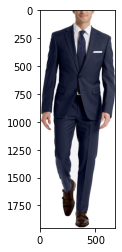

{'Suits/Blazers', 'Pants'}


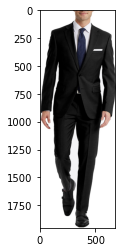

{'Suits/Blazers', 'Pants'}


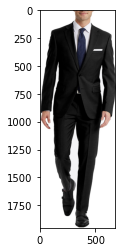

{'Suits/Blazers', 'Pants'}


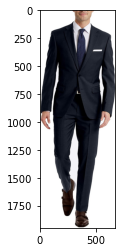

{'Suits/Blazers', 'Pants'}


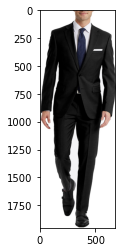

{'Suits/Blazers', 'Pants'}


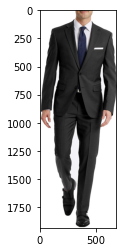

{'Suits/Blazers', 'Pants'}


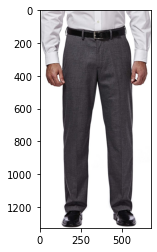

{'Suits/Blazers', 'Pants'}


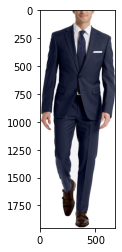

{'Suits/Blazers', 'Pants'}


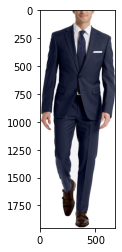

{'Suits/Blazers', 'Pants'}


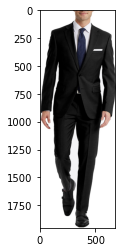

{'Suits/Blazers', 'Pants'}


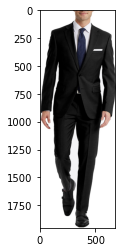

{'Suits/Blazers', 'Leather Jacket'}


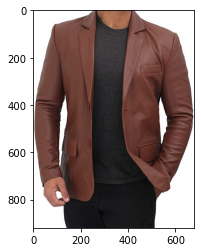

In [5]:
# Images in more than one record
duplicated_links = product_df[product_df.duplicated(subset=['img_src'])]['img_src']
# List to store images that has different labels
real_duplicates = []

for link in duplicated_links:
    # List of distinct labels
    temp_duplicates = set(product_df[product_df['img_src'] == link]['type'])
    # If all duplicates have same label, move to next image
    if len(temp_duplicates) != 1:
        real_duplicates.append(link)
        # Display the image
        name = link.split('/')[-1]
        path = f'../Data Collection/Data/Images/{name}'
        print(temp_duplicates)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()

We can see that most mislabels are between Pants and Suits. When pants of suits are sold, same images were used. But when we are training a classification model, we have to consider them as Suits. So we have to remove the pants.
Considering Leather jacket and Suits, both are look alike, so they can be trained for both for this particular image.

In [6]:
# Indexes of duplicate pants 
pant_index = product_df[(product_df['img_src'].isin(real_duplicates)) & (product_df['type'] == 'Pants')].index
# Remove the duplicates
product_df = product_df.drop(pant_index)

In [7]:
# Remove all other duplicates
product_df.drop_duplicates(subset=['img_src'], inplace=True)

> Pants are removed before removing other duplicates because we are not aware of the order in dataframe, and suits may be removed if we just use drop_duplicates 

## Resizing the image

Different images will have different dimensions, and it is neccesary to convert them into same dimension before modeling. We have convereted a sample image to standard dimension and visualized for reference.

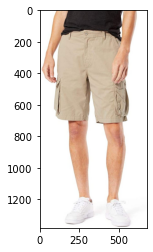

In [8]:
# Display the original image
image = cv2.imread('../Data Collection/Data/Images/51jvL+M952L._AC_UX679_.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

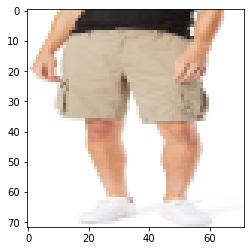

In [9]:
# Resize and display the image
dim = (72,72)
# resize image
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
new_image = resized.reshape(1,-1)
new_image = new_image.reshape(72,72,3)
plt.imshow(new_image)

## Image to Numerical data

Image needs to be converted into numerical data before modelling, so we have convereted all images into vectors and added them into a numpy array

In [10]:
# Arrays to store vectors and labels
image_label_arr = np.empty((0,1))
image_arr = np.empty((0,15552))

In [11]:
for row in product_df.iterrows():
    # Load the image
    img_src = row[1]['img_src']
    name = img_src.split('/')[-1]
    path = f'../Data Collection/Data/Images/{name}'
    image = cv2.imread(path)
    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except:
        continue
        
    # Resize the image
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    image = image.reshape(1,-1)
    # Append to the Numpy array
    image_arr = np.vstack([image_arr, image])
    image_label_arr = np.vstack([image_label_arr,row[1]['type']])

In [12]:
image_label_arr.shape

(874, 1)

In [13]:
image_arr.shape

(874, 15552)

In [14]:
# Save the numpy array as csv
np.savetxt("Data/image_array.csv", image_arr, delimiter=",")
np.savetxt("Data/image_label_array.csv", image_label_arr, delimiter=",", fmt='%s')